In [21]:
!pip install xgboost


   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
    --------------------------------------- 1.6/124.9 MB 8.3 MB/s eta 0:00:15
    --------------------------------------- 2.6/124.9 MB 7.2 MB/s eta 0:00:18
   - -------------------------------------- 4.5/124.9 MB 7.2 MB/s eta 0:00:17
   -- ------------------------------------- 6.6/124.9 MB 7.9 MB/s eta 0:00:15
   -- ------------------------------------- 8.4/124.9 MB 8.1 MB/s eta 0:00:15
   --- ------------------------------------ 10.5/124.9 MB 8.3 MB/s eta 0:00:14
   ---- ----------------------------------- 12.6/124.9 MB 8.5 MB/s eta 0:00:14
   ---- ----------------------------------- 14.4/124.9 MB 8.5 MB/s eta 0:00:13
   ----- ---------------------------------- 16.8/124.9 MB 8.7 MB/s eta 0:00:13
   ----- ---------------------------------- 18.6/124.9 MB 8.7 MB/s eta 0:00:13
   ------ --------------------------------- 20.4/124.9 MB 8.7 MB/s eta 0:00:12
   ------- -------------------------------- 22.0/124.9 MB 8.5 MB/

In [21]:
!pip install holidays

   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 1.2/1.2 MB 9.7 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pathlib import Path
import holidays

import utils
_target_column_name = "log_bike_count"

In [2]:
def get_data():
    # Define the starting directory (e.g., current directory)
    file_name = "train.parquet"
    start_dir = Path(".")  # Current directory

    # Search for the specific file
    parquet_file = next(start_dir.rglob(file_name), None)

    if parquet_file:
        print(f"Loading file: {parquet_file}")
        
        # Load the Parquet file into a pandas DataFrame
        df = pd.read_parquet(parquet_file)  # Use the found file path

        # y_array = df["log_bike_count"].values
        # X_df = df[["date", "counter_name"]]
        df = df[["date", "counter_name", "bike_count", "log_bike_count"]]
        return df
    else:
        print(f"File '{file_name}' not found in the directory.")


In [3]:
def merge_ext_data(X):
    # Define the starting directory (e.g., current directory)
    file_name = "external_data.csv"
    start_dir = Path(".")  # Current directory

    # Search for the specific file
    csv_file = next(start_dir.rglob(file_name), None)

    if csv_file:
        print(f"Loading file: {csv_file}")
        
        # Load the Parquet file into a pandas DataFrame
        df_ext = pd.read_csv(csv_file)  # Use the found file path
        df_ext = df_ext.fillna(0)
        df_ext["date"] = df_ext["date"].astype('datetime64[us]')
        X = X.copy()
        X["orig_index"] = np.arange(X.shape[0])
        X = pd.merge_asof(
        X.sort_values("date"), df_ext[["date", "t", "etat_sol", 'rr1', 'rr12', "ff", "ht_neige" ]].sort_values("date"), on="date")
        X = X.sort_values("orig_index")
        X["rr1"] = abs(X["rr1"])
        X["rr3"] = abs(X["rr12"])
        del X["orig_index"]

        df_expanded = X.loc[X.index.repeat(3)].reset_index(drop=True)
        # Add hourly intervals to the timestamp
        df_expanded["date"] += pd.to_timedelta(df_expanded.groupby(df_expanded.index // 3).cumcount(), unit="h")
        # Sort by timestamp
        df_expanded = df_expanded.sort_values("date").reset_index(drop=True)
        return X
    else:
        print(f"File '{file_name}' not found in the directory.")


In [4]:
# Fonction pour définir les périodes de confinement
def set_periods(df, column_name, periods):
    df[column_name] = 0
    for start_date, end_date in periods:
        df.loc[(df['date'] >= start_date) & (df['date'] < end_date), column_name] = 1

In [5]:
def encode_dates(X):
    X = X.copy()  # modify a copy of X
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour
    X["weekend_x_hour"] = np.where(X["weekday"].isin([5, 6]), 'weekend_', 'weekday_') + X["hour"].astype(str)
    fr_holidays = holidays.France(years=[(2015 + i) for i in range(10)])
    X["is_red_day"] = X["date"].dt.date.isin(fr_holidays.keys()).astype(int)
    # Définir les périodes de confinement
    lockdown_periods = [
        ('2020-10-30', '2020-12-15'),
        ('2021-04-03', '2021-05-04')
    ]
    set_periods(X, 'Lockdown', lockdown_periods)

    # Définir les périodes de couvre-feu souple
    soft_curfew_periods = [
        ('2020-10-17', '2020-10-30'),
        ('2020-12-15', '2021-01-16'),
        ('2021-05-19', '2021-06-21')
        ]
    set_periods(X, 'soft-curfew', soft_curfew_periods)

    # Définir les périodes de couvre-feu strict
    hard_curfew_periods = [
        ('2021-01-16', '2021-04-03'),
        ('2021-05-04', '2021-05-19')]

    X = X.drop(columns=["date", "hour"])

    return X

In [6]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [7]:
data = get_data()
y = data["log_bike_count"].values
X = data[["date", "counter_name"]]
X = merge_ext_data(X)

date_encoder = FunctionTransformer(encode_dates)
date_cols = encode_dates(X[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "etat_sol"]
numerical_cols = ['ff', 'rr1', 'rr12', 't', 'ht_neige']

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("num", StandardScaler(), numerical_cols)
    ]
)


Loading file: data\train.parquet
Loading file: data\external_data.csv


In [8]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):
    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]
    return X_train, y_train, X_valid, y_valid

X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y)

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn import ensemble
from sklearn.linear_model import Ridge
import xgboost as xgb

# params = {
#     "n_estimators": 300,
#     "max_depth": 6,
#     "min_samples_split": 5,
#     "learning_rate": 0.1,
#     "loss": "squared_error",
# }

param = {
    'n_estimators': 500,  # 3 values
    'max_depth': 9,  # 3 values
    'learning_rate': 0.15,  # 2 values
    'subsample': 1.0,  # 1 values
    'colsample_bytree': 1.0,  # 1 values
    'reg_alpha': 0.1,  # 1 values
    'reg_lambda': 5  # 1 values
}

regressor = xgb.XGBRegressor(**param)
#regressor = RandomForestRegressor()
#regressor = Ridge(alpha=1)

pipe = make_pipeline(date_encoder, preprocessor, regressor)

In [ ]:

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import make_pipeline

# Define the XGBRegressor
regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Create the pipeline (add the date encoder, preprocessor, and XGB regressor)
pipe = make_pipeline(date_encoder, preprocessor, regressor)

# Parameter grid to search over (use double underscore notation to access regressor's params)
param_grid = {
    'xgbregressor__n_estimators': [300, 400, 500],  # 3 values
    'xgbregressor__max_depth': [6, 7, 8, 9],  # 3 values
    'xgbregressor__learning_rate': [0.1, 0.15, 0.2],  # 2 values
    'xgbregressor__subsample': [1.0, 0.5],  # 1 values
    'xgbregressor__colsample_bytree': [1.0],  # 1 values
    'xgbregressor__reg_alpha': [0.1, 0.5],  # 1 values
    'xgbregressor__reg_lambda': [5]  # 1 values
}

# Cross-validation split strategy
cv = TimeSeriesSplit(n_splits=4)

# Full Grid SearchCV
grid_search = GridSearchCV(
    estimator=pipe,  # The entire pipeline
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # Scoring metric
    cv=cv,
    verbose=2,  # Verbosity to track progress
    n_jobs=-1  # Use all available cores to parallelize
)

# Fit the model
grid_search.fit(X, y)

# Print the best parameters and the best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best RMSE: {-grid_search.best_score_:.4f}")


Fitting 4 folds for each of 144 candidates, totalling 576 fits
Best Parameters: {'xgbregressor__colsample_bytree': 1.0, 'xgbregressor__learning_rate': 0.15, 'xgbregressor__max_depth': 9, 'xgbregressor__n_estimators': 500, 'xgbregressor__reg_alpha': 0.1, 'xgbregressor__reg_lambda': 5, 'xgbregressor__subsample': 1.0}
Best RMSE: 0.8899


In [14]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=4)

# Perform cross-validation with negative root mean squared error as the scoring metric
scores = cross_val_score(pipe, X, y, cv=cv, scoring="neg_root_mean_squared_error")

# Print individual scores and summary statistics
print("Individual Fold RMSEs:")
for i, score in enumerate(scores, start=1):
    print(f"Fold {i}: RMSE = {-score:.3f}")

# Calculate and display mean and standard deviation of the RMSEs
rmse_scores = -scores  # Convert to positive
print(f"\nRMSE (all folds): {rmse_scores.mean():.3f} ± {rmse_scores.std():.3f}")

Individual Fold RMSEs:
Fold 1: RMSE = 0.728
Fold 2: RMSE = 0.694
Fold 3: RMSE = 0.961
Fold 4: RMSE = 1.176

RMSE (all folds): 0.890 ± 0.195


In [15]:
pipe.fit(X_train, y_train)

# Make predictions on test data
test_predictions = pipe.predict(X_valid)

In [16]:


pipe.score(X_valid, y_valid)

0.8930908957239756

Text(0, 0.5, 'bike_count')

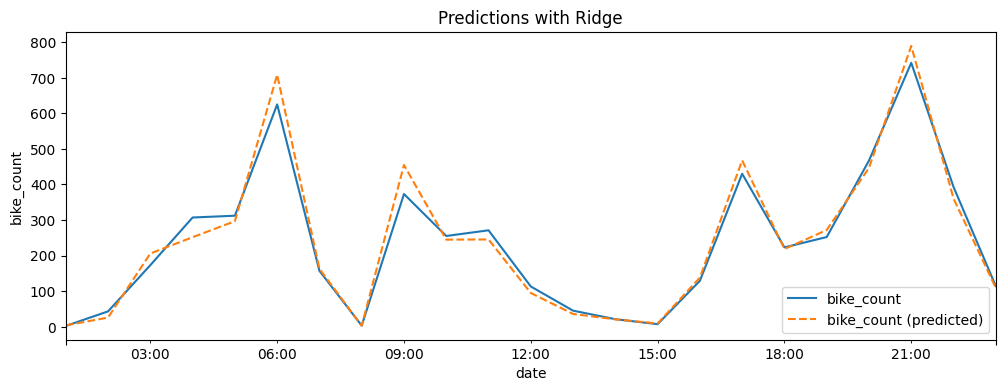

In [17]:
mask = (
    (X_train["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_train["date"] > pd.to_datetime("2021/05/04"))
    & (X_train["date"] < pd.to_datetime("2021/05/05"))
)

df_viz = X_train.loc[mask].copy().sort_values(by='date')
df_viz["bike_count"] = np.exp(y_train[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_train[mask])) - 1

fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

In [189]:
X_valid["date"].max()

Timestamp('2021-09-09 23:00:00')

In [198]:
mask = (
    (X_valid["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_valid["date"] > pd.to_datetime("2021/09/01"))
    & (X_valid["date"] < pd.to_datetime("2021/09/03"))
)

df_viz = X_valid.loc[mask].copy().sort_values(by='date')
df_viz["bike_count"] = np.exp(y_valid[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_valid[mask])) - 1

Text(0, 0.5, 'bike_count')

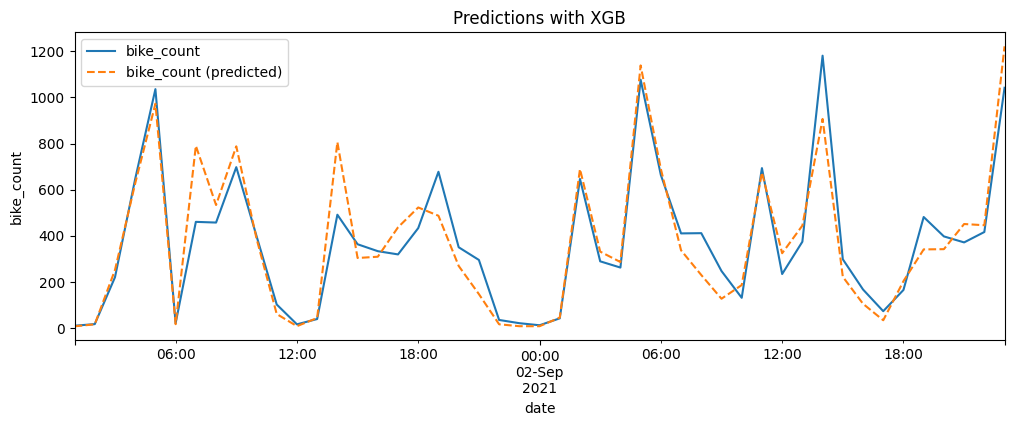

In [199]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with XGB")
ax.set_ylabel("bike_count")

Loading file: data\train.parquet


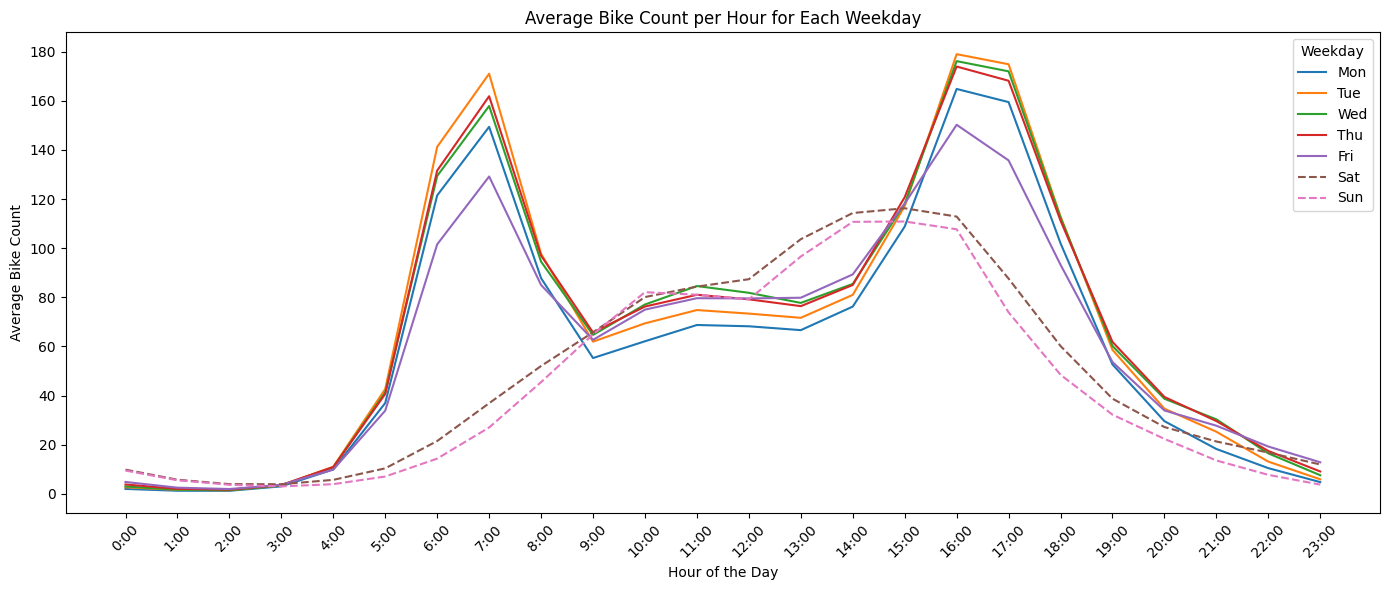

In [216]:
data = get_data()

df = pd.DataFrame(data)

# Convert the 'date' column to datetime format
df["date"] = pd.to_datetime(df["date"])

# Extract weekday (0 = Monday, 6 = Sunday) and hour from the 'date' column
df["weekday"] = df["date"].dt.weekday
df["hour"] = df["date"].dt.hour

# Group by 'weekday' and 'hour' and calculate the average bike_count
avg_bike_count = df.groupby(["weekday", "hour"])["bike_count"].mean().reset_index()

# Pivot the data so that hours are the columns and weekdays are the rows
avg_bike_count_pivot = avg_bike_count.pivot(index="weekday", columns="hour", values="bike_count")

# Reindex to ensure we have all hours (0-23) for each weekday (0-6)
avg_bike_count_pivot = avg_bike_count_pivot.reindex(columns=range(24), fill_value=0)

# Plot the average bike count per hour for each weekday
fig, ax = plt.subplots(figsize=(14, 6))

# Define linestyles for weekdays and weekends
weekday_linestyle = '-'  # Solid line for weekdays
weekend_linestyle = '--'  # Dashed line for weekends

# Plot each weekday as a separate line
for weekday in range(7):
    linestyle = weekend_linestyle if weekday in [5, 6] else weekday_linestyle  # Use dashed for Sat/Sun, solid for Mon-Fri
    ax.plot(
        avg_bike_count_pivot.columns, 
        avg_bike_count_pivot.loc[weekday], 
        label=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"][weekday], 
        linestyle=linestyle
    )

# Customizing the plot
ax.set_title("Average Bike Count per Hour for Each Weekday")
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Average Bike Count")
ax.set_xticks(range(0, 24, 1))  # Set x-ticks to represent each hour (0-23)
ax.set_xticklabels([f"{i}:00" for i in range(24)], rotation=45)  # Label hours in 24-hour format
ax.set_yticks(range(0, int(avg_bike_count_pivot.max().max()) + 20, 20))  # Y-ticks with some spacing
ax.legend(title="Weekday", loc='upper right')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

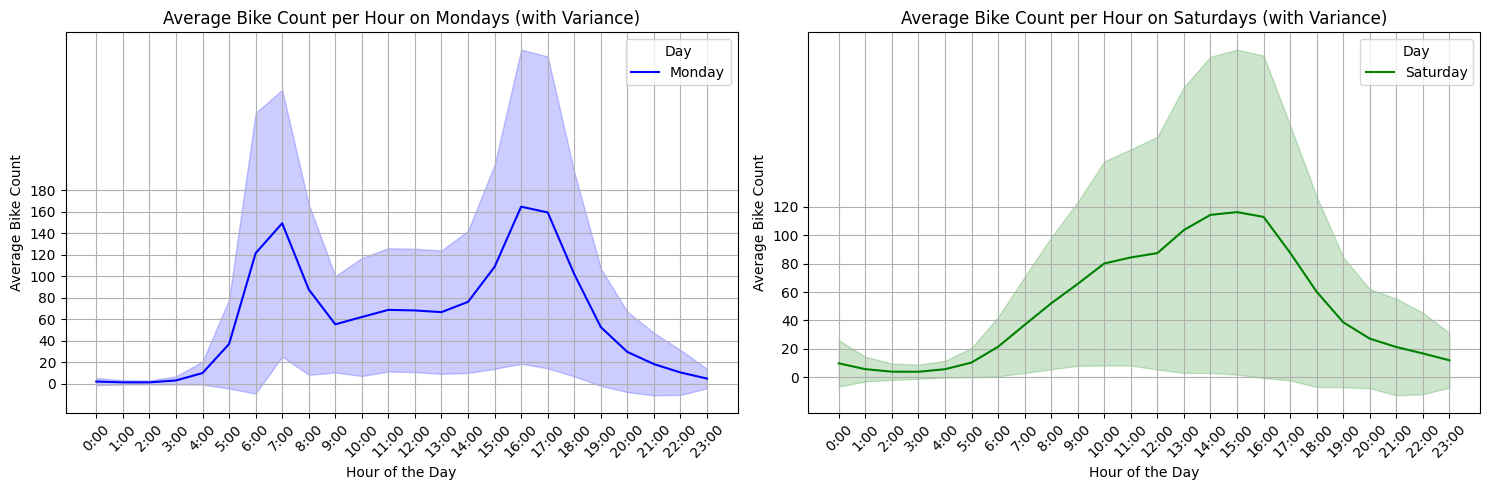

In [223]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame
df = pd.DataFrame(data)

# Convert the 'date' column to datetime format
df["date"] = pd.to_datetime(df["date"])

# Extract weekday (0 = Monday, 6 = Sunday) and hour from the 'date' column
df["weekday"] = df["date"].dt.weekday
df["hour"] = df["date"].dt.hour

# Define the weekdays we want to plot (Monday = 0, Saturday = 5)
days_of_interest = {"Monday": 0, "Saturday": 5}

# Create subplots (2 rows, 1 column)
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)

# Loop through Monday and Saturday to create the same plot for both days
for i, (day_name, weekday) in enumerate(days_of_interest.items()):
    
    # Filter for the current day
    day_df = df[df["weekday"] == weekday]
    
    # Group by 'hour' and calculate the mean and standard deviation for bike_count
    grouped = day_df.groupby("hour")["bike_count"].agg(["mean", "std"]).reset_index()
    
    # Extract mean and standard deviation values
    mean_values = grouped["mean"]
    std_values = grouped["std"]
    
    # Select the correct axis (either axes[0] or axes[1])
    ax = axes[i]
    
    # Plot the mean line
    ax.plot(
        grouped["hour"], 
        mean_values, 
        label=f"{day_name}", 
        linestyle='-', 
        color='blue' if day_name == "Monday" else 'green'
    )
    
    # Plot the shaded region (mean ± std)
    ax.fill_between(
        grouped["hour"], 
        mean_values - std_values, 
        mean_values + std_values, 
        color='blue' if day_name == "Monday" else 'green', 
        alpha=0.2  # Transparency for the variance
    )
    
    # Customizing the plot for each day
    ax.set_title(f"Average Bike Count per Hour on {day_name}s (with Variance)")
    ax.set_xlabel("Hour of the Day")
    ax.set_ylabel("Average Bike Count")
    ax.set_xticks(range(0, 24, 1))  # Set x-ticks to represent each hour (0-23)
    ax.set_xticklabels([f"{i}:00" for i in range(24)], rotation=45)  # Label hours in 24-hour format
    ax.set_yticks(range(0, int(mean_values.max()) + 20, 20))  # Y-ticks with some spacing
    ax.grid(True)
    ax.legend(title="Day", loc='upper right')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


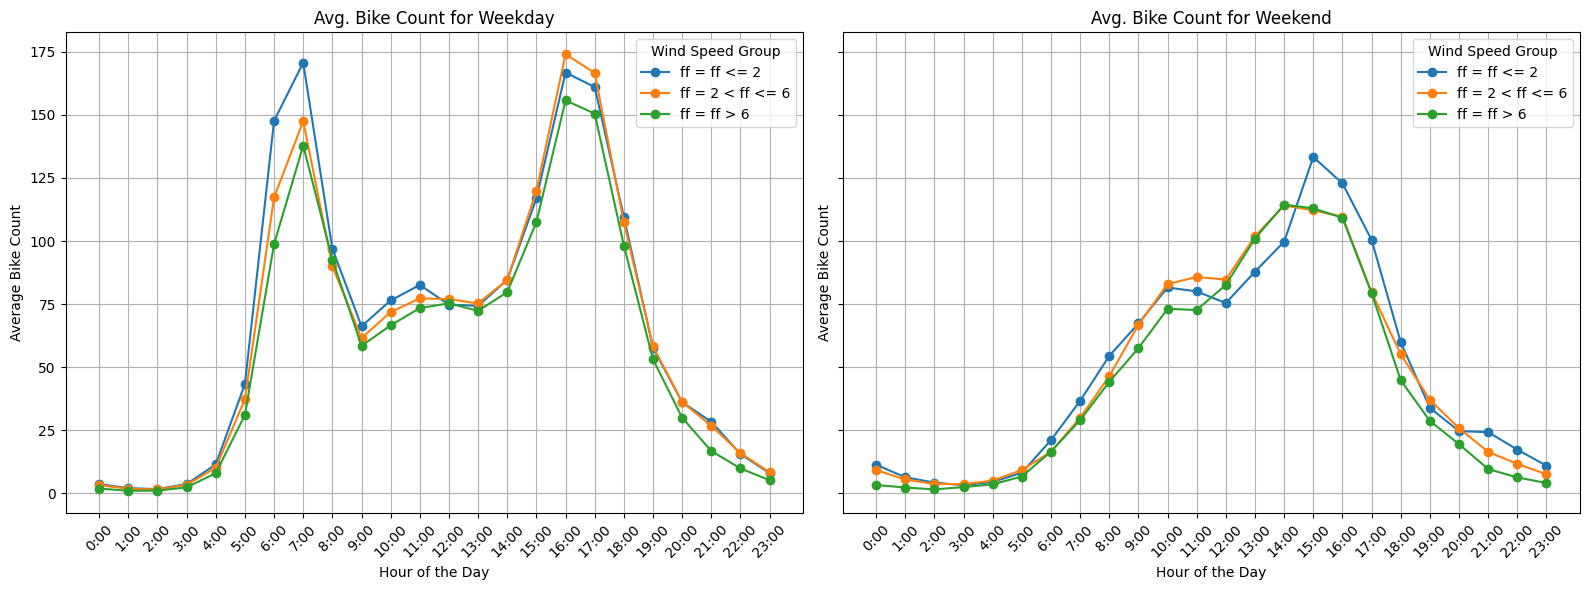

In [271]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame (replace with actual data)
df = pd.DataFrame(data)

# Convert the 'date' column to datetime format if not already done
df["date"] = pd.to_datetime(df["date"])

# Extract hour and weekday from the 'date' column
df["hour"] = df["date"].dt.hour
df["weekday"] = df["date"].dt.weekday

# Divide 'ff' into three groups based on the new conditions:
bins = [0, 2, 6, float('inf')]  # ff <= 2, 2 < ff <= 6, ff > 6
labels = ['ff <= 2', '2 < ff <= 6', 'ff > 6']

# Ensure that 'ff' is present in the DataFrame and then create the 'ff_group' column
if 'ff' in df.columns:
    df['ff_group'] = pd.cut(df['ff'], bins=bins, labels=labels)
else:
    print("Column 'ff' not found in DataFrame.")

# Create a new column to distinguish weekdays and weekends
df['day_type'] = df['weekday'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

# List of day types to plot
day_types_to_plot = {
    "Weekday": df[df['day_type'] == 'Weekday'],
    "Weekend": df[df['day_type'] == 'Weekend']
}

# Iterate over the day types (Weekday, Weekend) and plot
for i, (day_type_name, df_subset) in enumerate(day_types_to_plot.items()):
    
    # Select the current subplot axis
    ax = axes[i]
    
    # Iterate over the ff groups and plot the mean bike_count for each group
    for ff_group in labels:
        # Filter the subset of data for the current ff group
        df_ff_group = df_subset[df_subset["ff_group"] == ff_group]
        
        # Group by 'hour' and calculate the mean for bike_count
        grouped = df_ff_group.groupby("hour")["bike_count"].mean().reset_index()
        
        # Plot the mean curve for the current ff group
        ax.plot(
            grouped["hour"], 
            grouped["bike_count"], 
            label=f"ff = {ff_group}", 
            linestyle='-', 
            marker='o'
        )
    
    # Customizing the plot
    ax.set_title(f"Avg. Bike Count for {day_type_name}")
    ax.set_xlabel("Hour of the Day")
    ax.set_ylabel("Average Bike Count")
    ax.set_xticks(range(0, 24, 1))  # Set x-ticks to represent each hour (0-23)
    ax.set_xticklabels([f"{i}:00" for i in range(24)], rotation=45)  # Label hours in 24-hour format
    ax.grid(True)
    ax.legend(title="Wind Speed Group", loc='upper right')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


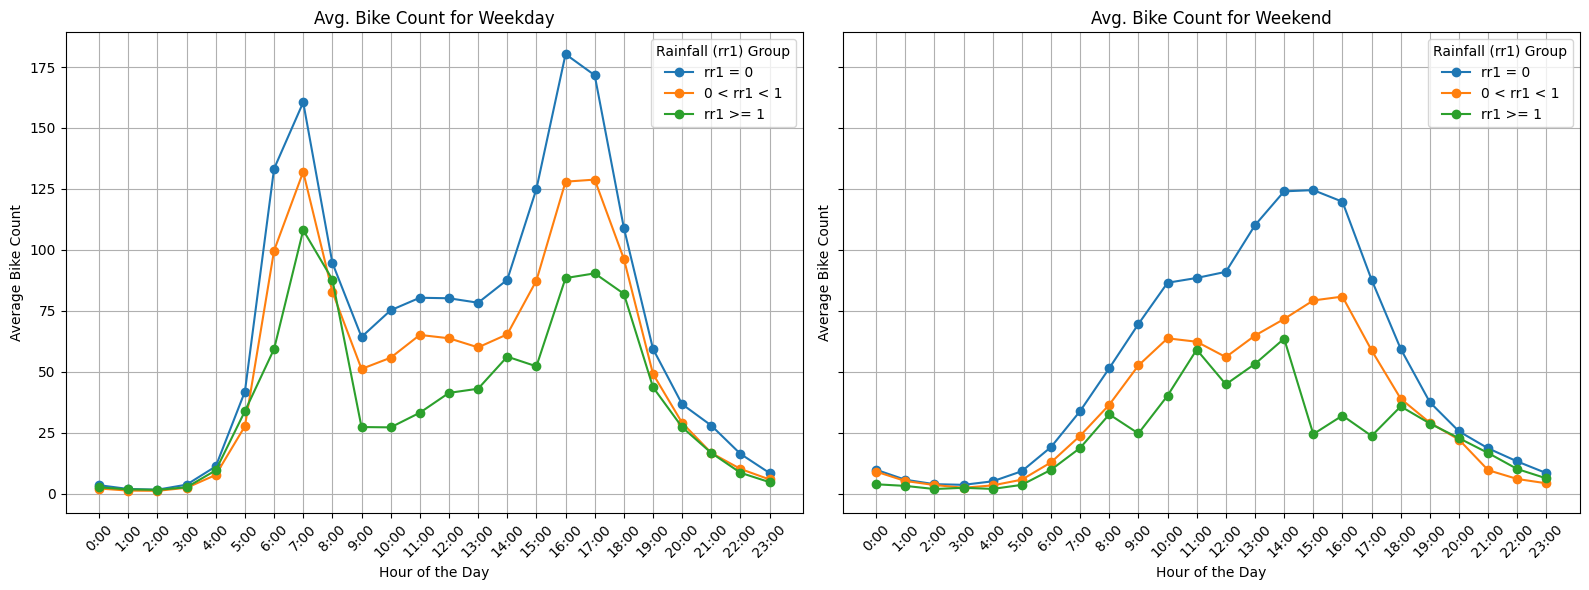

In [290]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame (replace with actual data)
df = pd.DataFrame(data)

# Convert the 'date' column to datetime format if not already done
df["date"] = pd.to_datetime(df["date"])

# Extract hour and weekday from the 'date' column
df["hour"] = df["date"].dt.hour
df["weekday"] = df["date"].dt.weekday

# Create a new column to distinguish weekdays and weekends
df['day_type'] = df['weekday'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Divide 'rr1' into three groups based on the new conditions:
def classify_rr1(x):
    if x == 0:
        return 'rr1 = 0'
    elif 0 < x < 1:
        return '0 < rr1 < 1'
    else:
        return 'rr1 >= 1'

df['rr1_group'] = df['rr1'].apply(classify_rr1)

# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

# List of day types to plot
day_types_to_plot = {
    "Weekday": df[df['day_type'] == 'Weekday'],
    "Weekend": df[df['day_type'] == 'Weekend']
}

# Iterate over the day types (Weekday, Weekend) and plot
for i, (day_type_name, df_subset) in enumerate(day_types_to_plot.items()):
    
    # Select the current subplot axis
    ax = axes[i]
    
    # Iterate over the rr1 groups and plot the mean bike_count for each group
    for rr1_group in ['rr1 = 0', '0 < rr1 < 1', 'rr1 >= 1']:
        # Filter the subset of data for the current rr1 group
        df_rr1_group = df_subset[df_subset["rr1_group"] == rr1_group]
        
        # Group by 'hour' and calculate the mean for bike_count
        grouped = df_rr1_group.groupby("hour")["bike_count"].mean().reset_index()
        
        # Plot the mean curve for the current rr1 group
        ax.plot(
            grouped["hour"], 
            grouped["bike_count"], 
            label=f"{rr1_group}", 
            linestyle='-', 
            marker='o'
        )
    
    # Customizing the plot
    ax.set_title(f"Avg. Bike Count for {day_type_name}")
    ax.set_xlabel("Hour of the Day")
    ax.set_ylabel("Average Bike Count")
    ax.set_xticks(range(0, 24, 1))  # Set x-ticks to represent each hour (0-23)
    ax.set_xticklabels([f"{i}:00" for i in range(24)], rotation=45)  # Label hours in 24-hour format
    ax.grid(True)
    ax.legend(title="Rainfall (rr1) Group", loc='upper right')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


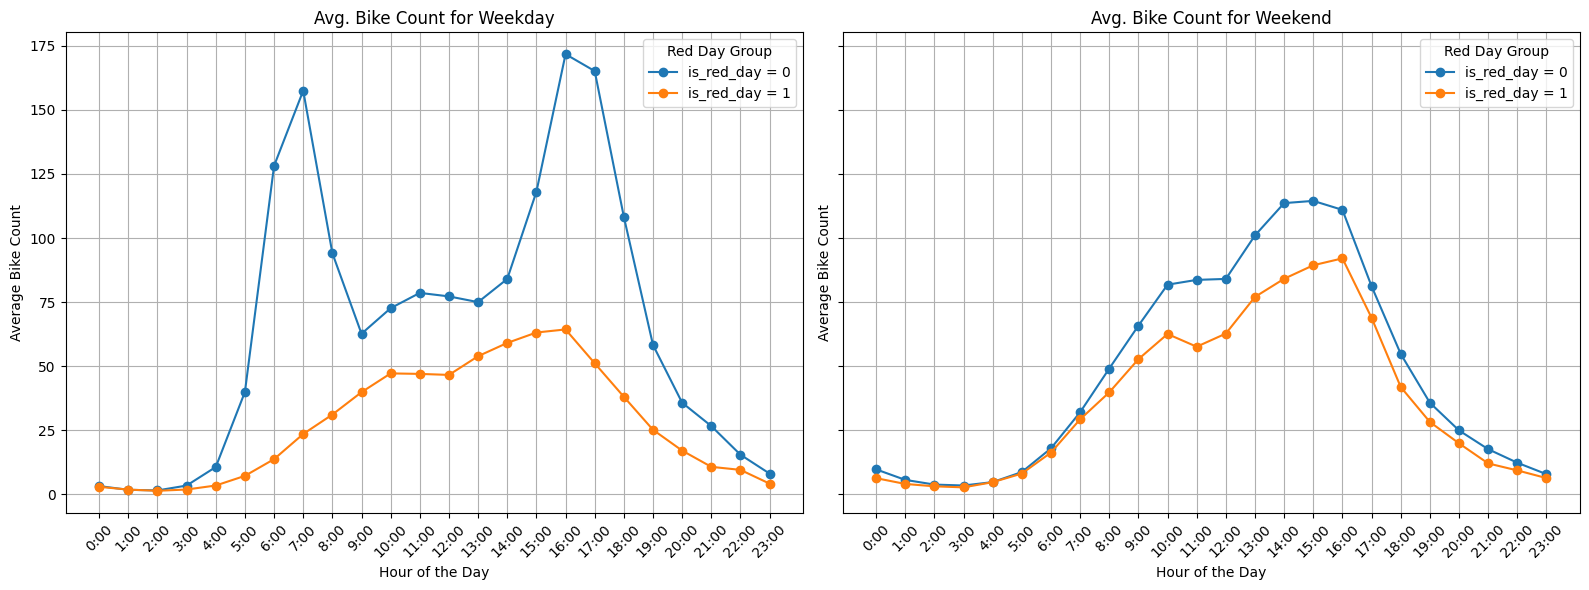

In [292]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame (replace with actual data)
df = pd.DataFrame(data)

# Convert the 'date' column to datetime format if not already done
df["date"] = pd.to_datetime(df["date"])
fr_holidays = holidays.France(years=[(2015 + i) for i in range(10)])
df["is_red_day"] = df["date"].dt.date.isin(fr_holidays.keys()).astype(int)

# Extract hour and weekday from the 'date' column
df["hour"] = df["date"].dt.hour
df["weekday"] = df["date"].dt.weekday

# Create a new column to distinguish weekdays and weekends
df['day_type'] = df['weekday'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

# List of day types to plot
day_types_to_plot = {
    "Weekday": df[df['day_type'] == 'Weekday'],
    "Weekend": df[df['day_type'] == 'Weekend']
}

# Iterate over the day types (Weekday, Weekend) and plot
for i, (day_type_name, df_subset) in enumerate(day_types_to_plot.items()):
    
    # Select the current subplot axis
    ax = axes[i]
    
    # Iterate over the 'is_red_day' groups (0 or 1)
    for red_day_value in [0, 1]:
        # Filter the subset of data for the current 'is_red_day' value
        df_red_day = df_subset[df_subset["is_red_day"] == red_day_value]
        
        # Group by 'hour' and calculate the mean for bike_count
        grouped = df_red_day.groupby("hour")["bike_count"].mean().reset_index()
        
        # Plot the mean curve for the current 'is_red_day' value
        ax.plot(
            grouped["hour"], 
            grouped["bike_count"], 
            label=f"is_red_day = {red_day_value}", 
            linestyle='-', 
            marker='o'
        )
    
    # Customizing the plot
    ax.set_title(f"Avg. Bike Count for {day_type_name}")
    ax.set_xlabel("Hour of the Day")
    ax.set_ylabel("Average Bike Count")
    ax.set_xticks(range(0, 24, 1))  # Set x-ticks to represent each hour (0-23)
    ax.set_xticklabels([f"{i}:00" for i in range(24)], rotation=45)  # Label hours in 24-hour format
    ax.grid(True)
    ax.legend(title="Red Day Group", loc='upper right')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


<Axes: >

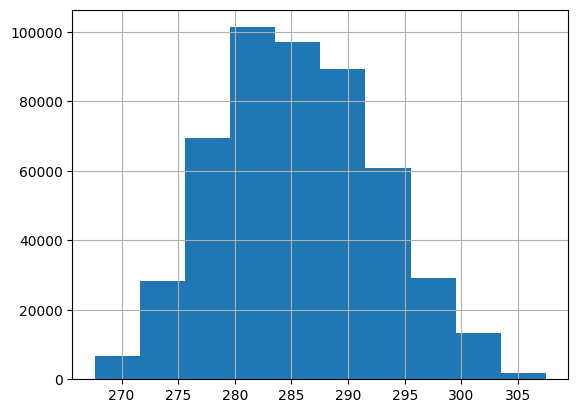

In [294]:
df["t"].hist()

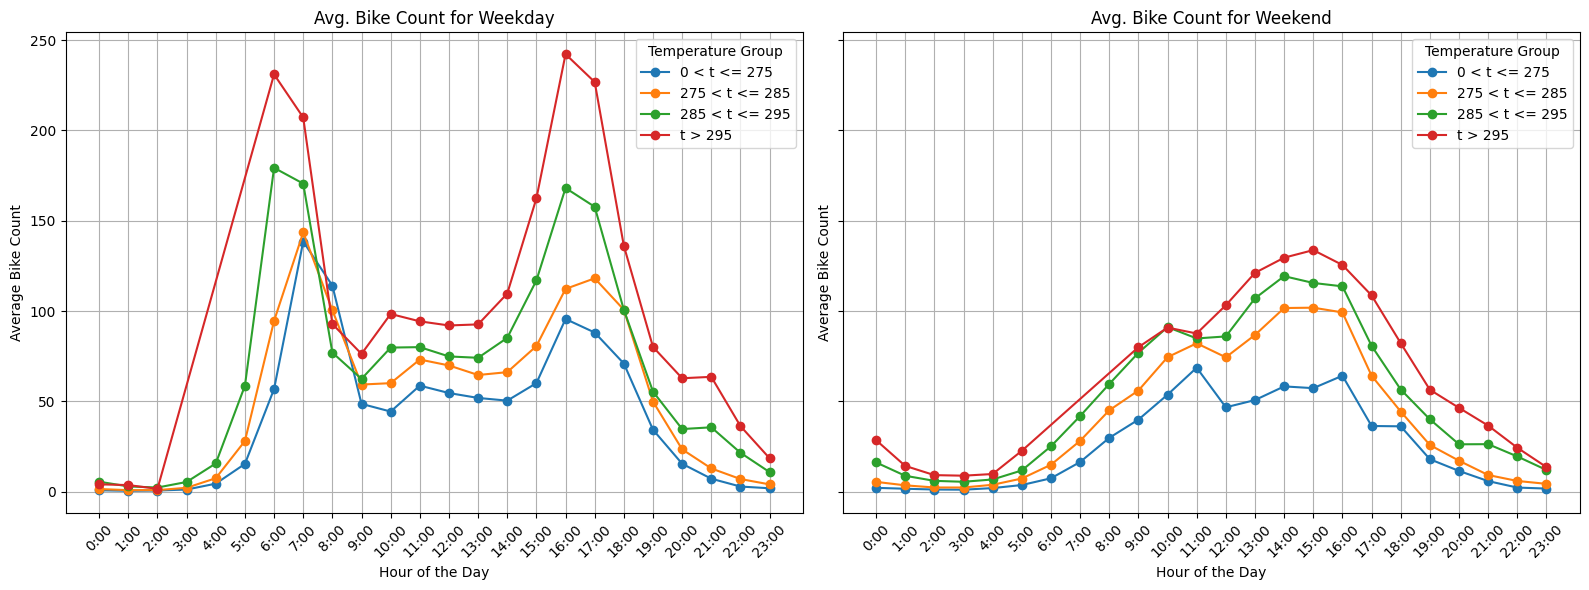

In [305]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame (replace with actual data)
df = pd.DataFrame(data)

# Convert the 'date' column to datetime format if not already done
df["date"] = pd.to_datetime(df["date"])

# Extract hour and weekday from the 'date' column
df["hour"] = df["date"].dt.hour
df["weekday"] = df["date"].dt.weekday

# Create a new column to distinguish weekdays and weekends
df['day_type'] = df['weekday'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Define the bins for 't' column
bins = [0, 275, 285, 295, 400]
labels = ['0 < t <= 275', '275 < t <= 285', '285 < t <= 295', 't > 295']  # 5 labels for 5 bins

# Create the 't_group' column based on the bins and labels
df['t_group'] = pd.cut(df['t'], bins, labels=labels, right=True)

# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

# List of day types to plot
day_types_to_plot = {
    "Weekday": df[df['day_type'] == 'Weekday'],
    "Weekend": df[df['day_type'] == 'Weekend']
}

# Iterate over the day types (Weekday, Weekend) and plot
for i, (day_type_name, df_subset) in enumerate(day_types_to_plot.items()):
    
    # Select the current subplot axis
    ax = axes[i]
    
    # Iterate over the 't_group' values and plot the mean bike_count for each group
    for t_group in labels:
        # Filter the subset of data for the current 't_group' value
        df_t_group = df_subset[df_subset["t_group"] == t_group]
        
        # Group by 'hour' and calculate the mean for bike_count
        grouped = df_t_group.groupby("hour")["bike_count"].mean().reset_index()
        
        # Plot the mean curve for the current 't_group' value
        ax.plot(
            grouped["hour"], 
            grouped["bike_count"], 
            label=f"{t_group}", 
            linestyle='-', 
            marker='o'
        )
    
    # Customizing the plot
    ax.set_title(f"Avg. Bike Count for {day_type_name}")
    ax.set_xlabel("Hour of the Day")
    ax.set_ylabel("Average Bike Count")
    ax.set_xticks(range(0, 24, 1))  # Set x-ticks to represent each hour (0-23)
    ax.set_xticklabels([f"{i}:00" for i in range(24)], rotation=45)  # Label hours in 24-hour format
    ax.grid(True)
    ax.legend(title="Temperature Group", loc='upper right')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [296]:
data

,date,counter_name,bike_count,log_bike_count,t,etat_sol,rr1,rr3,rr6,ff
107,2020-09-01 02:00:00,28 boulevard Diderot E-O,0.0,0.000000,285.75,0.0,0.0,0.0,0.0,1.6
153,2020-09-01 03:00:00,28 boulevard Diderot E-O,1.0,0.693147,283.95,0.0,0.0,0.0,0.0,1.1
201,2020-09-01 04:00:00,28 boulevard Diderot E-O,0.0,0.000000,283.95,0.0,0.0,0.0,0.0,1.1
782,2020-09-01 15:00:00,28 boulevard Diderot E-O,4.0,1.609438,293.65,0.0,0.0,0.0,0.0,4.0
925,2020-09-01 18:00:00,28 boulevard Diderot E-O,9.0,2.302585,292.15,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...
495819,2021-09-09 06:00:00,254 rue de Vaugirard SO-NE,445.0,6.100319,292.85,1.0,0.0,0.0,0.1,2.3
496091,2021-09-09 10:00:00,254 rue de Vaugirard SO-NE,145.0,4.983607,293.45,0.0,0.0,0.0,0.0,3.5
496354,2021-09-09 15:00:00,254 rue de Vaugirard SO-NE,218.0,5.389072,299.35,0.0,0.0,0.0,0.0,5.5
496719,2021-09-09 22:00:00,254 rue de Vaugirard SO-NE,21.0,3.091042,292.25,1.0,0.0,0.0,0.6,1.6
